In [1]:
from scipy import io
import os
import os.path as osp
from scipy import sparse
import dgl
import torch
import pandas as pd
from tsnecuda import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

Using backend: pytorch


# Loading Graphs:

- N: directed heterogeneous graph in homogeneous form: post+user by post+user

N has following composition:

- U: directed homogeneous graph: user by user (user replies user)
- PU: directed heterogeneous graph: post by user (post written by author)
- UP: directed heterogeneous graph: user by post (first level user reply post & author writes post)

In [2]:
fp = '/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data'

In [3]:
graph = io.loadmat(osp.join(fp, 'interim', 'graph', 'graph.mat'))

In [4]:
graph

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon May 25 13:58:18 2020',
 '__version__': '1.0',
 '__globals__': [],
 'N': <585320x585320 sparse matrix of type '<class 'numpy.int64'>'
 	with 2604806 stored elements in Compressed Sparse Column format>,
 'U': <481907x481907 sparse matrix of type '<class 'numpy.int64'>'
 	with 805055 stored elements in Compressed Sparse Column format>,
 'A': <481907x103413 sparse matrix of type '<class 'numpy.int64'>'
 	with 103413 stored elements in Compressed Sparse Column format>,
 'P': <103413x481907 sparse matrix of type '<class 'numpy.int64'>'
 	with 1696338 stored elements in Compressed Sparse Column format>,
 'post_label': array([[0, 0, 0, ..., 0, 0, 0]]),
 'post_cate': <103413x47 sparse matrix of type '<class 'numpy.float64'>'
 	with 103413 stored elements in Compressed Sparse Column format>,
 'post_indx': array([[  6614,   6616,   6628, ..., 257041, 257042, 257043]]),
 'user_indx': array([[     0,      1,      2, ..., 585317, 

In [5]:
N, U, A, P = graph['N'], graph['U'], graph['A'], graph['P']
post_label = graph['post_label']
post_cate = graph['post_cate']

# P Graph

## general EDA

In [6]:
#spread of the post
pd.Series(post_label[0]).value_counts()

0    99004
1     4409
dtype: int64

## percentage of users only post once 

In [7]:
np.count_nonzero(P.sum(axis = 0).getA()[0] == 1)/len(P.sum(axis = 0).getA()[0])

0.45097913082814733

In [8]:
temp = np.argmax(post_cate, axis=1).getA()

In [9]:
from scipy.sparse import coo_matrix, hstack
Post_subred = hstack([P,temp]).toarray()

In [10]:
#total number of replies for users in each subreddit
sub_P = Post_subred[Post_subred[:,-1]  == 0][:,:-1]
result = sub_P.sum(axis = 0)
for i in np.arange(1,47):
    sub_P = Post_subred[Post_subred[:,-1]  == i][:,:-1]
    result = np.vstack([result, sub_P.sum(axis = 0)])

## proportion of users post only in 1 subreddit

In [11]:
reply_sub = (result != 0).sum(0) #number of subreddits involve with for each user
np.count_nonzero(reply_sub == 1) / len(reply_sub) 

0.8546109519056582

# Hateful post users
Def: users who has comment/write under a hateful post

In [12]:
#hateful post index
hate_index = np.where(post_label[0] == 1)[0]


In [13]:
#total number of replies for users in each subreddit only on users for hateful post
Post_subred_h = Post_subred[hate_index,:]
sub_P = Post_subred_h[Post_subred_h[:,-1]  == 0][:,:-1]
result_h = sub_P.sum(axis = 0)
for i in np.arange(1,47):
    sub_P = Post_subred_h[Post_subred_h[:,-1]  == i][:,:-1]
    result_h = np.vstack([result_h, sub_P.sum(axis = 0)])

### Proportion of users that are engage in a hateful speech that only post once in a subreddit
Numerator: Number of Users who has comment/write under a hateful post comment or post only once in any subreddit

Denominator: Total number of users who has comment/write under a hateful post

In [14]:
#users engage in hateful post
user_h = np.where(result_h.sum(axis = 0) != 0)[0]
post_user_h = result[:,user_h]

In [15]:
(np.count_nonzero(post_user_h.sum(axis = 0) == 1))/len(post_user_h.sum(axis = 0))

0.20035876914585346

In [16]:
#percentage of user involved in hateful posts
len(post_user_h[0])/len(result[0])

0.07519085632705065

In [17]:
#total number of users
len(result[0])

481907

### Proportion of users that are engage in a hateful speech post only in 1 subreddit
Numerator: Number of Users who has comment/write under a hateful post comment or post only once in any subreddit

Denominator: Total number of users who has comment/write under a hateful post

In [18]:
reply_sub_h = (post_user_h != 0).sum(0) #number of subreddits involve with for each user
np.count_nonzero(reply_sub_h == 1) / len(reply_sub_h) 

0.7003173727059473

In [19]:
pd.Series(reply_sub_h).value_counts()

1     25376
2      7042
3      2317
4       872
5       344
6       165
7        59
8        32
9        11
10        5
13        3
11        3
15        2
14        2
25        1
21        1
dtype: int64

## Users that appears in multiple hateful post

In [37]:
#number of times a users post/comment in a hateful post
Users_post = P[hate_index,:].sum(axis = 0)
pd.Series(Users_post.A[0]).value_counts()

0      445672
1       22867
2        6302
3        2738
4        1438
5         776
6         523
7         372
8         260
9         191
10        152
11        107
12         85
13         63
14         61
16         42
15         37
17         31
19         25
18         18
20         14
21         14
28         11
24         11
29         11
22          9
23          8
26          7
34          6
32          5
30          5
25          4
35          4
42          3
31          3
44          3
81          2
52          2
47          2
43          2
33          2
39          2
41          1
27          1
84          1
87          1
67          1
65          1
62          1
58          1
51          1
40          1
50          1
49          1
36          1
46          1
45          1
37          1
104         1
dtype: int64

In [38]:
len(user_h)

36235

In [ ]:
users_connections = TSNE(n_components=2).fit_transform(post_user_h)

In [12]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(0.14716473, -0.2565376, '0'), Text(1.0636724, 0.1412639, '1')])

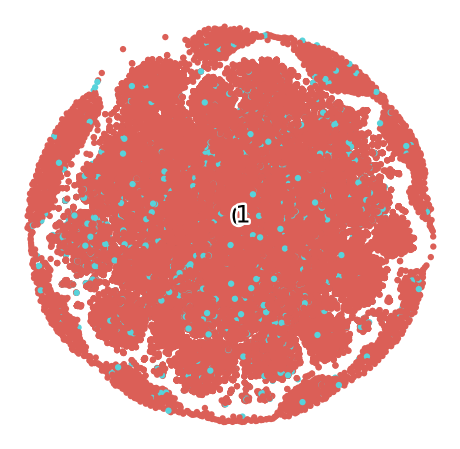

In [39]:
fashion_scatter(P, post_label[0])

In [40]:
pd.Series(post_label[0]).value_counts()

0    99004
1     4409
dtype: int64

### number of nodes and number of edges

In [10]:
print(g)

DGLGraph(num_nodes=483173, num_edges=103413,
         ndata_schemes={}
         edata_schemes={})


In [11]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 0.21402892959664552 edges per node


### Node Statistics

in degree stats

In [8]:
indegree = g.in_degrees(g.nodes()).numpy()

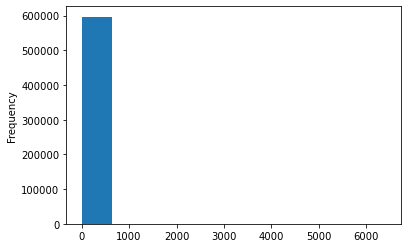

In [9]:
pd.Series(indegree).plot(kind = 'hist')

In [10]:
pd.Series(indegree).describe()

count    596681.000000
mean          3.091491
std          22.275691
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max        6416.000000
dtype: float64

omitt outliers

In [11]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).describe()

count    591536.000000
mean          1.998957
std           4.681746
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          47.000000
dtype: float64

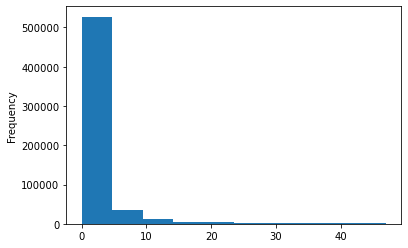

In [12]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).plot(kind = 'hist')

most of in nodes have indegree 1 between 2 and 10

In [13]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree > 2)]).describe()

count    72325.000000
mean         4.909907
std          1.859802
min          3.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          9.000000
dtype: float64

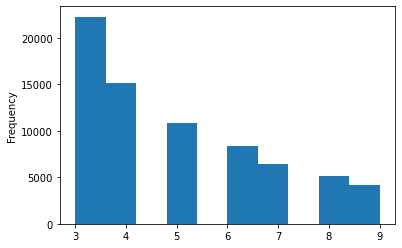

In [14]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree > 2)]).plot(kind = 'hist')

out degree stats

In [15]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [16]:
pd.Series(outdegree).describe()

count    596681.000000
mean          3.091491
std          48.376868
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       30768.000000
dtype: float64

omitt outliers

In [17]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).describe()

count    595672.000000
mean          2.706678
std           5.963406
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          99.000000
dtype: float64

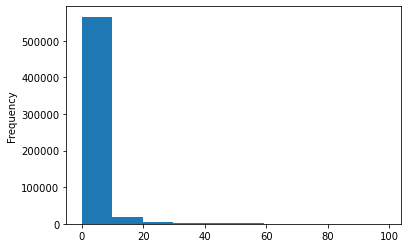

In [18]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).plot(kind='hist')

indegree between two and ten

In [19]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree > 2)]).describe()

count    96517.000000
mean         4.634572
std          1.777630
min          3.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          9.000000
dtype: float64

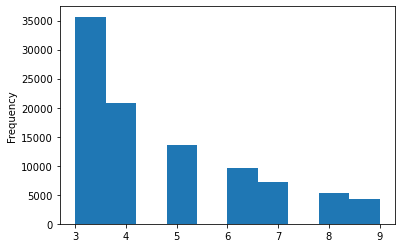

In [20]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree > 2)]).plot(kind='hist')

The in degree and out degree have the same distribution, and the graph is very sparse.

# U Graph


In [26]:
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(U)
g.edata['weight'] = torch.from_numpy(U_edge_weight)

## number of nodes and number of edges

In [27]:
print(g)

DGLGraph(num_nodes=479723, num_edges=1610712,
         ndata_schemes={}
         edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})


In [28]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 3.357587607848696 edges per node


## Node Statistics
### In degree analysis

In [29]:
indegree = g.in_degrees(g.nodes()).numpy()

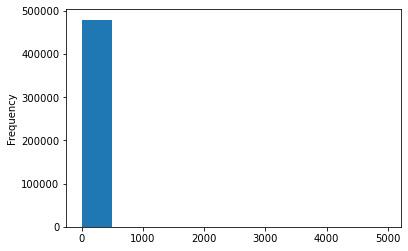

In [30]:
pd.Series(indegree).plot(kind = 'hist')

In [32]:
pd.Series(indegree).describe()

count    479723.000000
mean          3.357588
std          22.802664
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        4968.000000
dtype: float64

In [38]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).describe()

count    475103.000000
mean          2.122757
std           5.092450
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          48.000000
dtype: float64

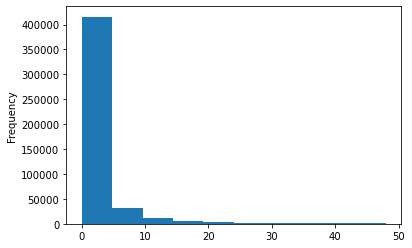

In [39]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).plot(kind = 'hist')

In [44]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree >= 0)]).value_counts(normalize = True)

0    0.582496
1    0.184501
2    0.081677
3    0.047461
4    0.031856
5    0.022753
6    0.017044
7    0.013151
8    0.010561
9    0.008500
dtype: float64

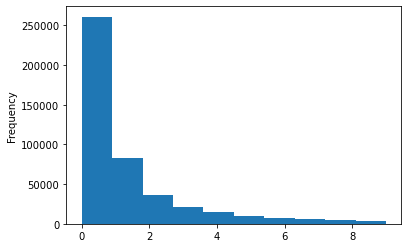

In [45]:
pd.Series(indegree[(indegree < (10)) & \
                   (indegree >= 0)]).plot(kind = 'hist')

In [46]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [49]:
pd.Series(outdegree).describe()

count    479723.000000
mean          3.357588
std          51.976645
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       29320.000000
dtype: float64

In [50]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).describe()

count    478942.000000
mean          2.951529
std           6.647182
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         107.000000
dtype: float64

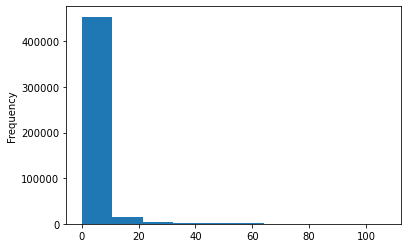

In [51]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).plot(kind='hist')

In [55]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree >= 0)]).value_counts(normalize = True)

1    0.488563
0    0.160454
2    0.151207
3    0.073185
4    0.043320
5    0.028403
6    0.019990
7    0.014804
8    0.011144
9    0.008930
dtype: float64

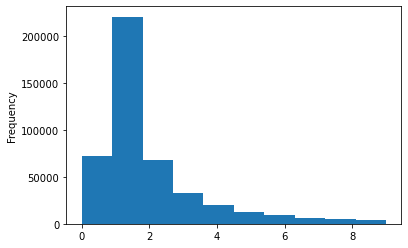

In [54]:
pd.Series(outdegree[(outdegree < 10) & \
                   (outdegree >= 0)]).plot(kind = 'hist')

# PU Graph

In [56]:
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(PU)
g.edata['weight'] = torch.from_numpy(PU_edge_weight)

In [57]:
print(g)

DGLGraph(num_nodes=479723, num_edges=116963,
         ndata_schemes={}
         edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})


In [58]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 0.243813617441732 edges per node


In [59]:
indegree = g.in_degrees(g.nodes()).numpy()

In [61]:
pd.Series(indegree).describe()

count    479723.000000
mean          0.243814
std           3.247989
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1448.000000
dtype: float64

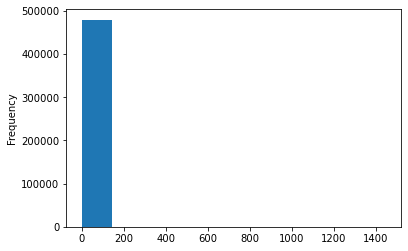

In [60]:
pd.Series(indegree).plot(kind = 'hist')

In [62]:
pd.Series(indegree[(indegree < (2 * indegree.std() + indegree.mean())) & \
                   (indegree > (indegree.mean() - 2 * indegree.std()))]).describe()

count    478003.000000
mean          0.177886
std           0.554717
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
dtype: float64

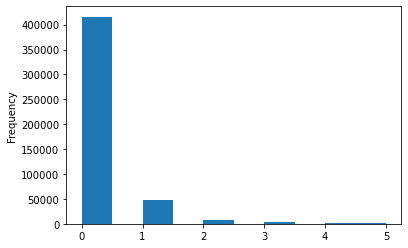

In [63]:
pd.Series(indegree[(indegree < (6)) & \
                   (indegree >= 0)]).plot(kind = 'hist')

In [64]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [65]:
pd.Series(outdegree).describe()

count    479723.000000
mean          0.243814
std           0.429435
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
dtype: float64

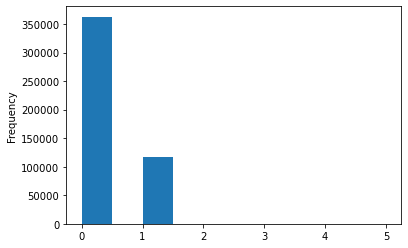

In [67]:
pd.Series(outdegree).plot(kind = 'hist')

# UP Graph

In [68]:
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(UP)
g.edata['weight'] = torch.from_numpy(UP_edge_weight)

In [69]:
print(g)

DGLGraph(num_nodes=479723, num_edges=116959,
         ndata_schemes={}
         edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float64)})


In [70]:
print('average {} edges per node'.format(len(g.edges)/len(g.nodes)))

average 0.24380527929659407 edges per node


In [71]:
indegree = g.in_degrees(g.nodes()).numpy()

In [72]:
pd.Series(indegree).describe()

count    479723.000000
mean          0.243805
std           0.429382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
dtype: float64

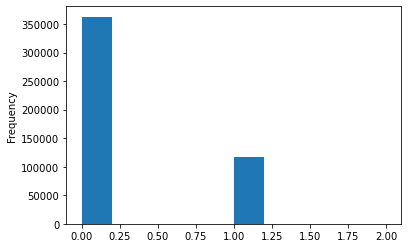

In [73]:
pd.Series(indegree).plot(kind = 'hist')

In [74]:
outdegree = g.out_degrees(g.nodes()).numpy()

In [75]:
pd.Series(outdegree).describe()

count    479723.000000
mean          0.243805
std           3.247923
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1448.000000
dtype: float64

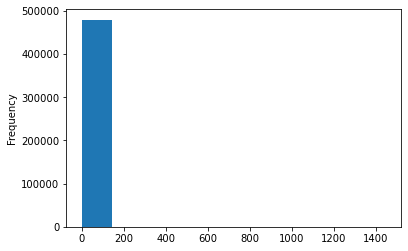

In [76]:
pd.Series(outdegree).plot(kind = 'hist')

In [77]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).describe()

count    478003.000000
mean          0.177880
std           0.554706
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
dtype: float64

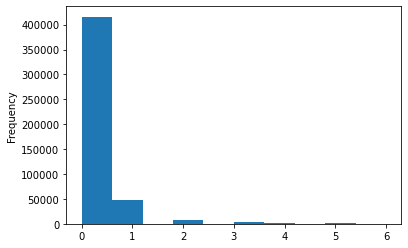

In [78]:
pd.Series(outdegree[(outdegree < (2 * outdegree.std() + outdegree.mean())) & \
                   (outdegree > (outdegree.mean() - 2 * outdegree.std()))]).plot(kind = 'hist')